In [83]:
# pip install google-api-python-client
# !pip install argparse
# !pip install beautifulsoup4
# !pip install nltk
!pip install WordCloud

     -------------------------------------- 153.3/153.3 kB 3.1 MB/s eta 0:00:00


In [86]:
from googleapiclient.discovery import build
from IPython.display import JSON
import pandas as pd
import argparse
import isodate

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
api_key = "ADD YOUR API KEY HERE"

In [48]:
channel_ids = ["UCoOae5nYA7VqaXzerajD0lg"]

In [49]:
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "YOUR_CLIENT_SECRET_FILE.json"

# Get credentials and create an API client
youtube = build(
        api_service_name, api_version, developerKey=api_key)


In [50]:
def get_channel_stats(youtube,channel_ids):
    all_data = []

    request = youtube.channels().list(
            part="snippet,contentDetails,statistics",
            id=",".join(channel_ids)
    )
    response = request.execute()
    
    #loop throughj items 
    for item in response["items"]:
        data = {"channelName": item["snippet"]["title"],
                "subscribers": item["statistics"]["subscriberCount"],
                "views": item["statistics"]["viewCount"],
                "totalViews": item["statistics"]["videoCount"],
                "playlistId": item["contentDetails"]["relatedPlaylists"]["uploads"]
               }
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [51]:
channel_stats = get_channel_stats(youtube,channel_ids)

In [52]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Ali Abdaal,4680000,354092981,692,UUoOae5nYA7VqaXzerajD0lg


In [53]:
# playlist_id='UCoOae5nYA7VqaXzerajD0lg'

In [54]:
playlist_id='UUoOae5nYA7VqaXzerajD0lg'
def get_video_ids(youtube,playlist_id):
        video_ids = []

        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 50
        )
        response = request.execute()
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
    
        next_page_token = response.get('nextPageToken')
        while next_page_token is not None:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId=playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for item in response['items']:
                video_ids.append(item['contentDetails']['videoId'])
    
            next_page_token = response.get('nextPageToken')

        return video_ids



In [55]:
video_id = get_video_ids(youtube,playlist_id)

In [56]:
len(video_id)

689

In [57]:
## this code is for getting the video details about 
def get_video_details(youtube,video_ids):

    all_video_info = []
    
    for i in range(0,len(video_ids),50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        
        for video in response["items"]:
            stats_to_keep = {"snippet":["channelTitle","title","description","tags","publishedAt"],
                             "statistics":["viewCount","likeCount","favoriteCount","commentCount"],
                            "contentDetails":["duration","defination","caption"]
                            }
            video_info = {}
            video_info["video_ids"] = video["id"]
            
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v]=video[k][v]
                    except:
                        video_info[v] = None
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)



In [58]:
video_df = get_video_details(youtube,video_id)

In [59]:
video_df

,video_ids,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,defination,caption
0,nQyuCT_zzok,Ali Abdaal,The Relationship Life Dinner 🍽️,"📚 If you liked this, you might like my new boo...","[Ali Abdaal, Ali abdal]",2023-09-07T12:00:40Z,5972,754,0,17,PT55S,None,false
1,BgVIAGA4wmQ,Ali Abdaal,This editing tool will save you so much time 🧑‍💻,Try Firecut now for free: https://firecut.ai/,"[Ali Abdaal, Ali abdal]",2023-09-06T12:04:12Z,28869,2935,0,39,PT37S,None,false
2,Y-d90cILIDk,Ali Abdaal,8 Powerful Laws of Success That Changed My Life,"The first 1,000 people to use the link will ge...","[Ali Abdaal, Ali abdal, motivational video, in...",2023-09-05T15:00:20Z,116226,5217,0,188,PT18M33S,None,true
3,OksWjaMxUOQ,Ali Abdaal,How Eric Yuan Founded Zoom 🧑‍💻,"📚 If you liked this, you might like my new boo...","[Ali Abdaal, Ali abdal]",2023-09-04T12:00:19Z,21574,1384,0,13,PT49S,None,false
4,vBqOMLd1ZQk,Ali Abdaal,8 Surprising Habits to Get Millions of Subscri...,Take the YouTube Growth Scorecard to discover ...,"[Ali Abdaal, Ali abdal, ali abdaal productivit...",2023-09-01T17:00:36Z,100071,5157,0,215,PT11M53S,None,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04T23:13:51Z,85996,2146,0,121,PT2M35S,None,false
685,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09T18:45:18Z,15516,108,0,5,PT2M11S,None,false
686,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27T09:04:49Z,38380,280,0,9,PT2M18S,None,false
687,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05T09:05:29Z,56779,714,0,33,PT2M29S,None,false


In [60]:
# def get_comments_in_video(youtube,video_ids):

#     all_comments = []
    
#     for i in range(0,len(video_ids),50):
#         request = youtube.videos().list(
#             part="snippet,replies",
#             videoId=video_ids
#         )
#         response = request.execute()
        
#         comments_in_video = [comment["snippet"]["topLevelComment"]["snippet"]["textOriginal"] for comment in response]
#         comments_in_video_info = {"video_id":video_id,"comment":comments_in_video}
        
#         all_comments.append(comments_in_video_info)
    
#     return pd.DataFrame(all_comments)

In [61]:
# comments_df = get_comments_in_video(youtube,video_ids)

In [62]:
# comments_df

## Data Pre-Prcessing

In [63]:
video_df.isnull().any()

video_ids        False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
viewCount        False
likeCount        False
favoriteCount    False
commentCount     False
duration         False
defination        True
caption          False
dtype: bool

In [64]:
video_df.dtypes

video_ids        object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
defination       object
caption          object
dtype: object

In [65]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [66]:
from bs4 import BeautifulSoup
parser = BeautifulSoup()

In [72]:
from dateutil import parser
import pandas as pd

# Assuming you have a DataFrame named video_df with a 'publishedAt' column

def parse_date(x):
    try:
        return parser.parse(x)
    except (ValueError, TypeError):
        return None

# Apply the parse_date function to the 'publishedAt' column
video_df['parsedPublishedAt'] = video_df['publishedAt'].apply(parse_date)

# Extract the day name from the parsed date
video_df['publishDayName'] = video_df['parsedPublishedAt'].apply(lambda x: x.strftime("%A"))

In [76]:
# convert duration to seconds

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [77]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,55.0,PT55S
1,37.0,PT37S
2,1113.0,PT18M33S
3,49.0,PT49S
4,713.0,PT11M53S
...,...,...
684,155.0,PT2M35S
685,131.0,PT2M11S
686,138.0,PT2M18S
687,149.0,PT2M29S


In [78]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [79]:
video_df

,video_ids,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,defination,caption,parsedPublishedAt,publishDayName,durationSecs,tagCount
0,nQyuCT_zzok,Ali Abdaal,The Relationship Life Dinner 🍽️,"📚 If you liked this, you might like my new boo...","[Ali Abdaal, Ali abdal]",2023-09-07T12:00:40Z,5972,754,0,17,PT55S,None,false,2023-09-07 12:00:40+00:00,Thursday,55.0,2
1,BgVIAGA4wmQ,Ali Abdaal,This editing tool will save you so much time 🧑‍💻,Try Firecut now for free: https://firecut.ai/,"[Ali Abdaal, Ali abdal]",2023-09-06T12:04:12Z,28869,2935,0,39,PT37S,None,false,2023-09-06 12:04:12+00:00,Wednesday,37.0,2
2,Y-d90cILIDk,Ali Abdaal,8 Powerful Laws of Success That Changed My Life,"The first 1,000 people to use the link will ge...","[Ali Abdaal, Ali abdal, motivational video, in...",2023-09-05T15:00:20Z,116226,5217,0,188,PT18M33S,None,true,2023-09-05 15:00:20+00:00,Tuesday,1113.0,22
3,OksWjaMxUOQ,Ali Abdaal,How Eric Yuan Founded Zoom 🧑‍💻,"📚 If you liked this, you might like my new boo...","[Ali Abdaal, Ali abdal]",2023-09-04T12:00:19Z,21574,1384,0,13,PT49S,None,false,2023-09-04 12:00:19+00:00,Monday,49.0,2
4,vBqOMLd1ZQk,Ali Abdaal,8 Surprising Habits to Get Millions of Subscri...,Take the YouTube Growth Scorecard to discover ...,"[Ali Abdaal, Ali abdal, ali abdaal productivit...",2023-09-01T17:00:36Z,100071,5157,0,215,PT11M53S,None,false,2023-09-01 17:00:36+00:00,Friday,713.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04T23:13:51Z,85996,2146,0,121,PT2M35S,None,false,2017-01-04 23:13:51+00:00,Wednesday,155.0,4
685,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09T18:45:18Z,15516,108,0,5,PT2M11S,None,false,2016-05-09 18:45:18+00:00,Monday,131.0,4
686,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27T09:04:49Z,38380,280,0,9,PT2M18S,None,false,2016-04-27 09:04:49+00:00,Wednesday,138.0,4
687,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05T09:05:29Z,56779,714,0,33,PT2M29S,None,false,2016-04-05 09:05:29+00:00,Tuesday,149.0,4


## Best performing videos

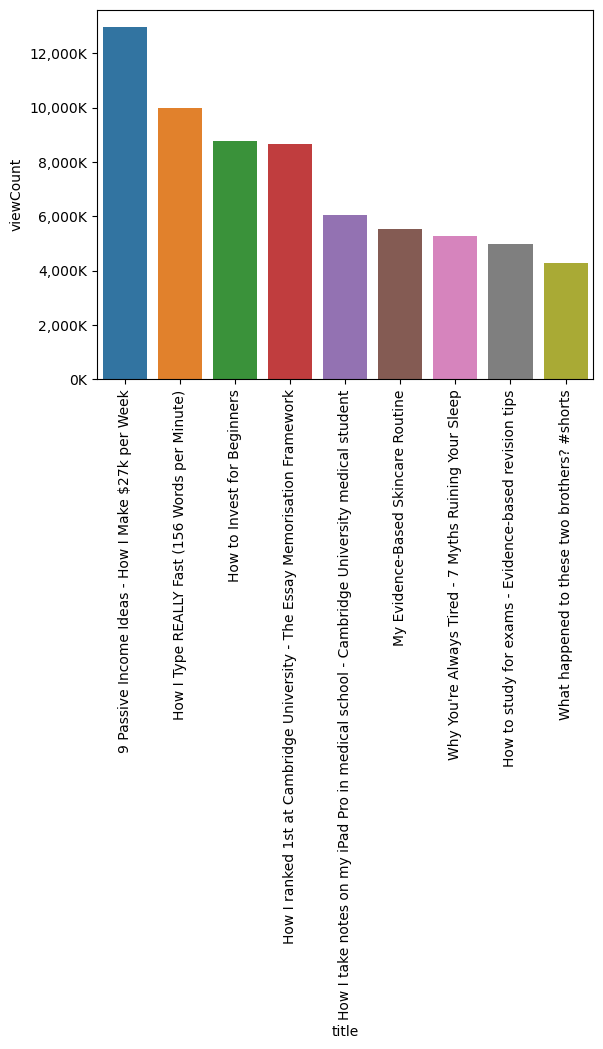

In [87]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127869 (\N{FORK AND KNIFE WITH PLATE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


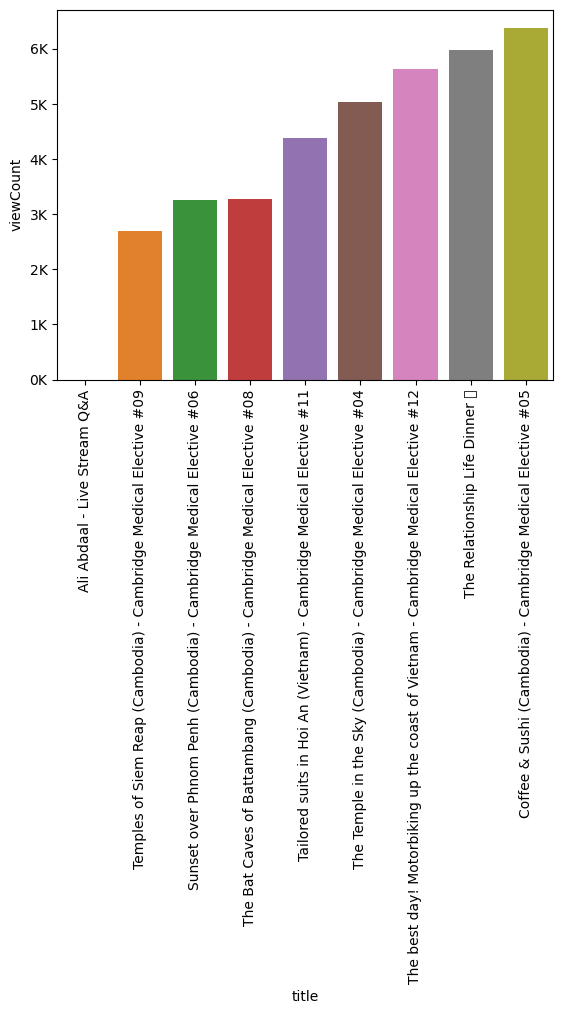

In [88]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

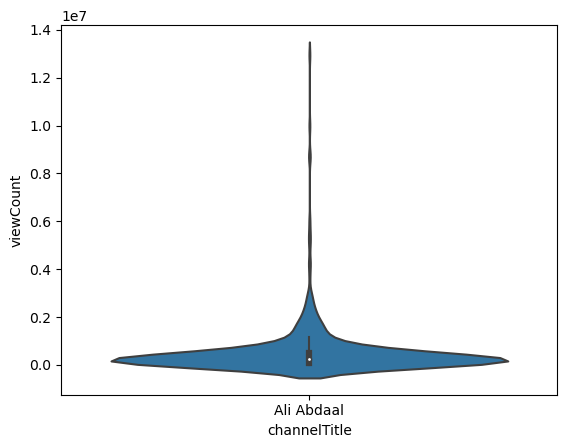

In [89]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

## Views vs. likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

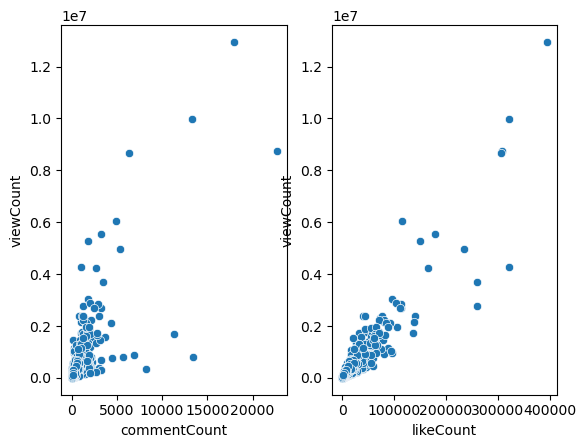

In [91]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

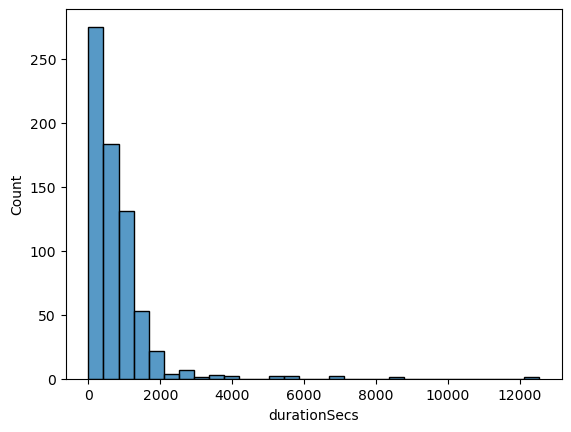

In [92]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Wordcloud for video titles

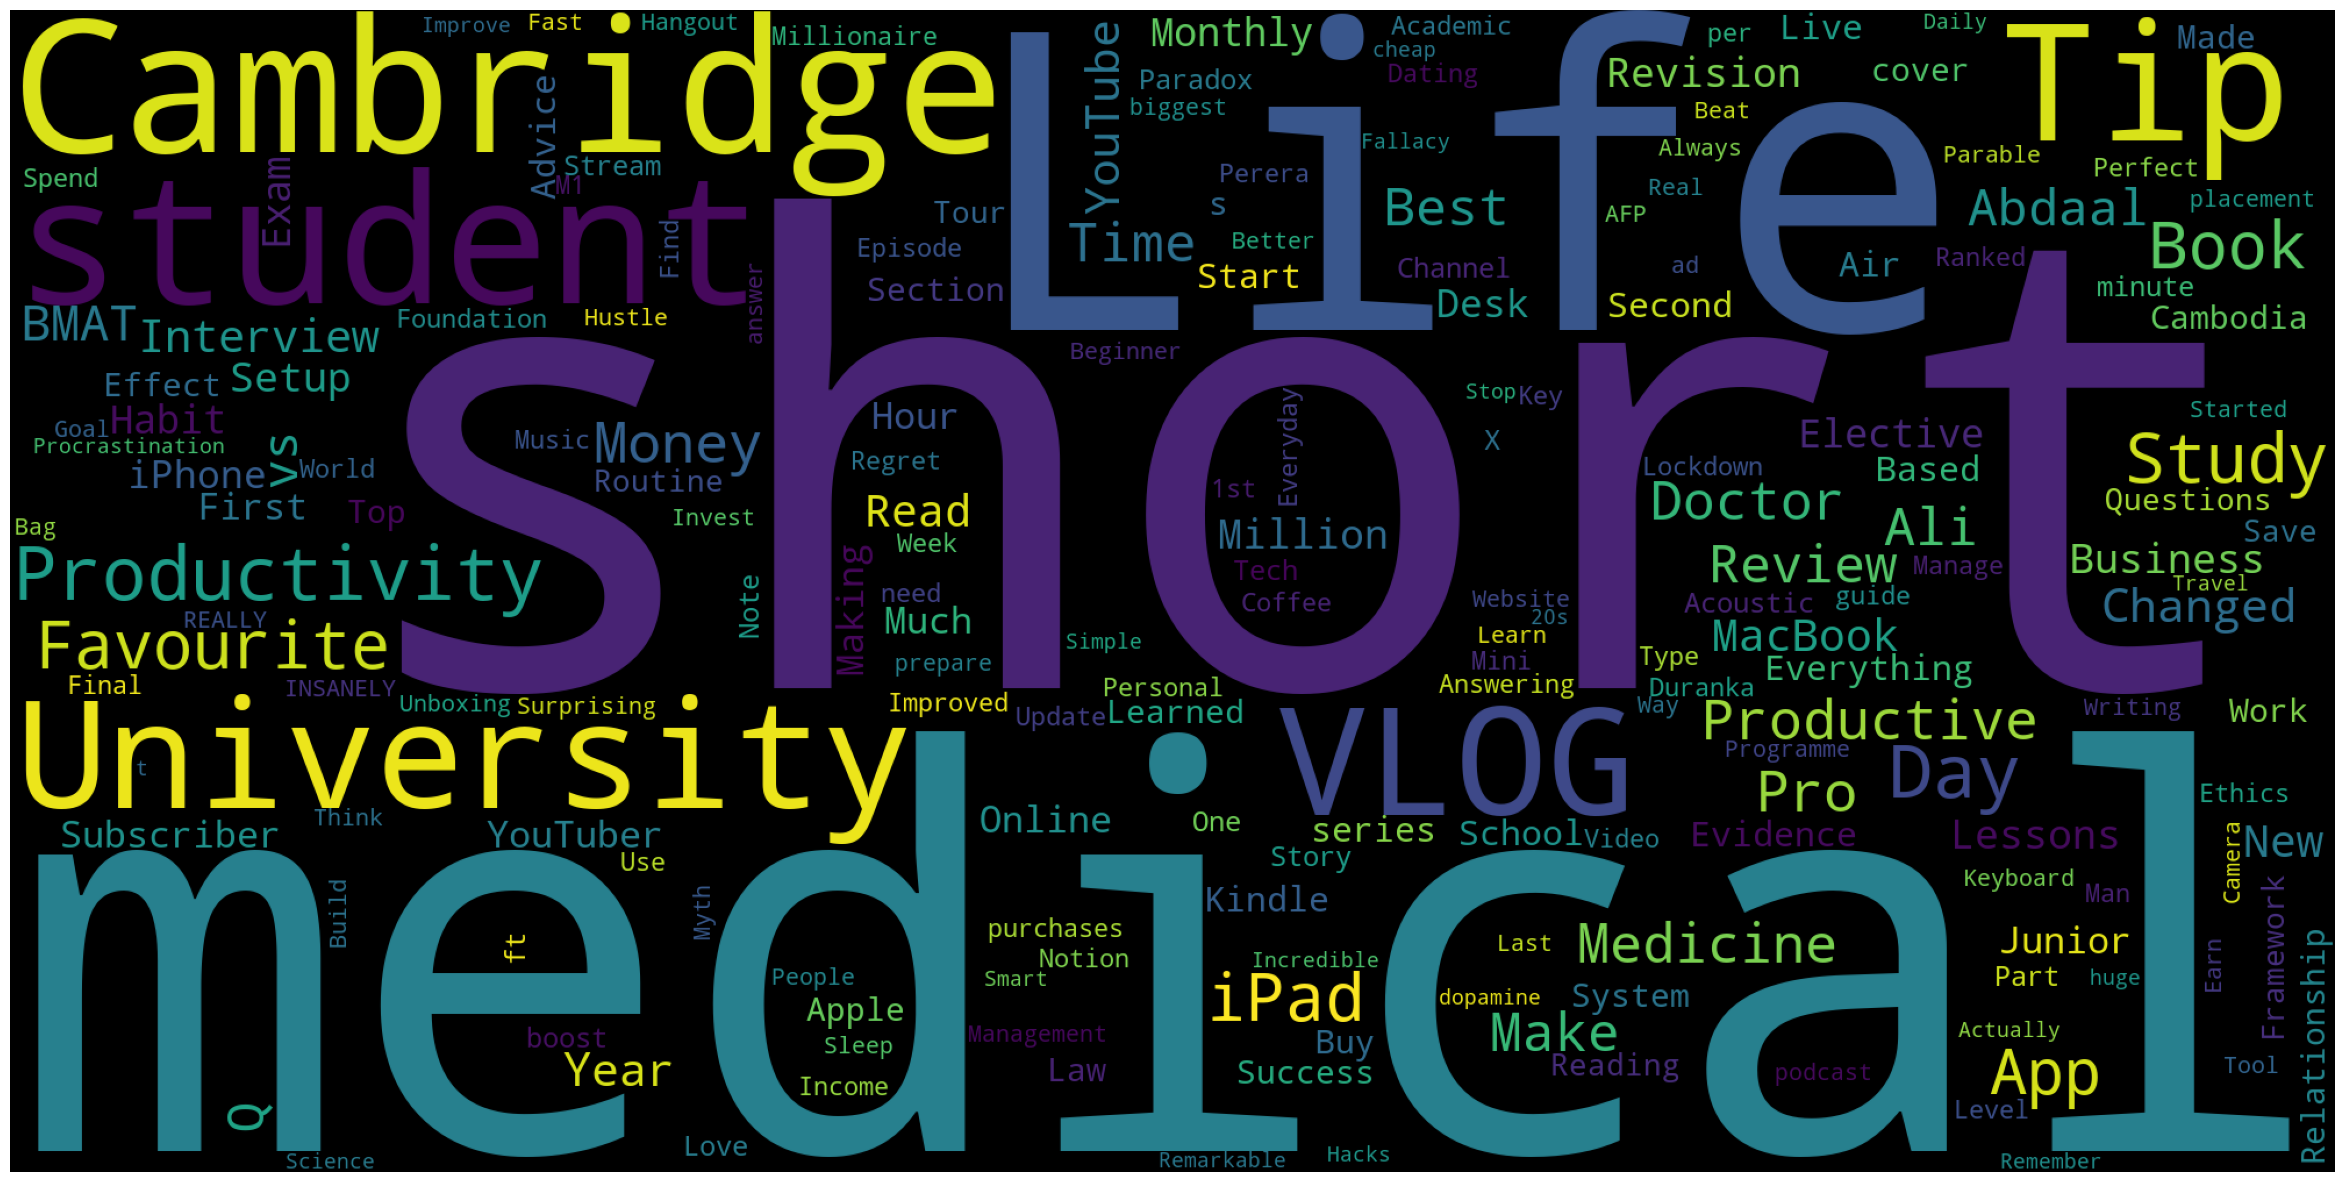

In [93]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Upload schedule

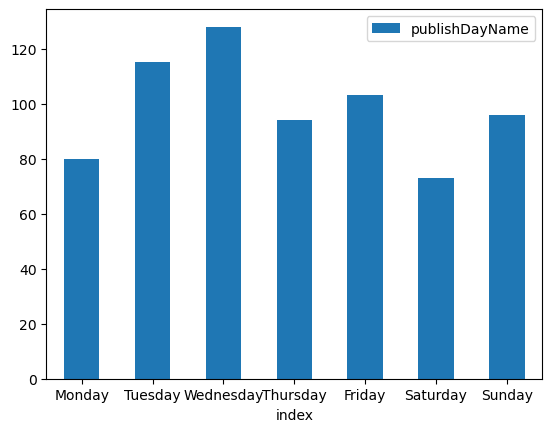

In [96]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)